<a href="https://www.kaggle.com/code/quangnhatbui/movie-recommender?scriptVersionId=132147249" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Movie recommendation

The notebook's is implemented here: https://movie-recommender-pi.vercel.app/

In this notebook, we are going to build a recommendation model for movies in 2 different ways, naming content based filtering and colaborative filtering. After that, we will attempt to combine the 2 methods to generate better recommendations for users who are presented in the dataset. Finally, we will conclude by finding a way to recommend movies for new users based on some of their favorite movies. 

## What is SVD exactly?
Feel free to skip this part if you already know what SVD is.

SVD stands for Singular Value Decomposition is a method of factorizing matrix. Given a mxn matrix A, it will factor A into 3 matrices:
- U: mxr matrix
- Σ: rxr matrix
- V: nxr matrix

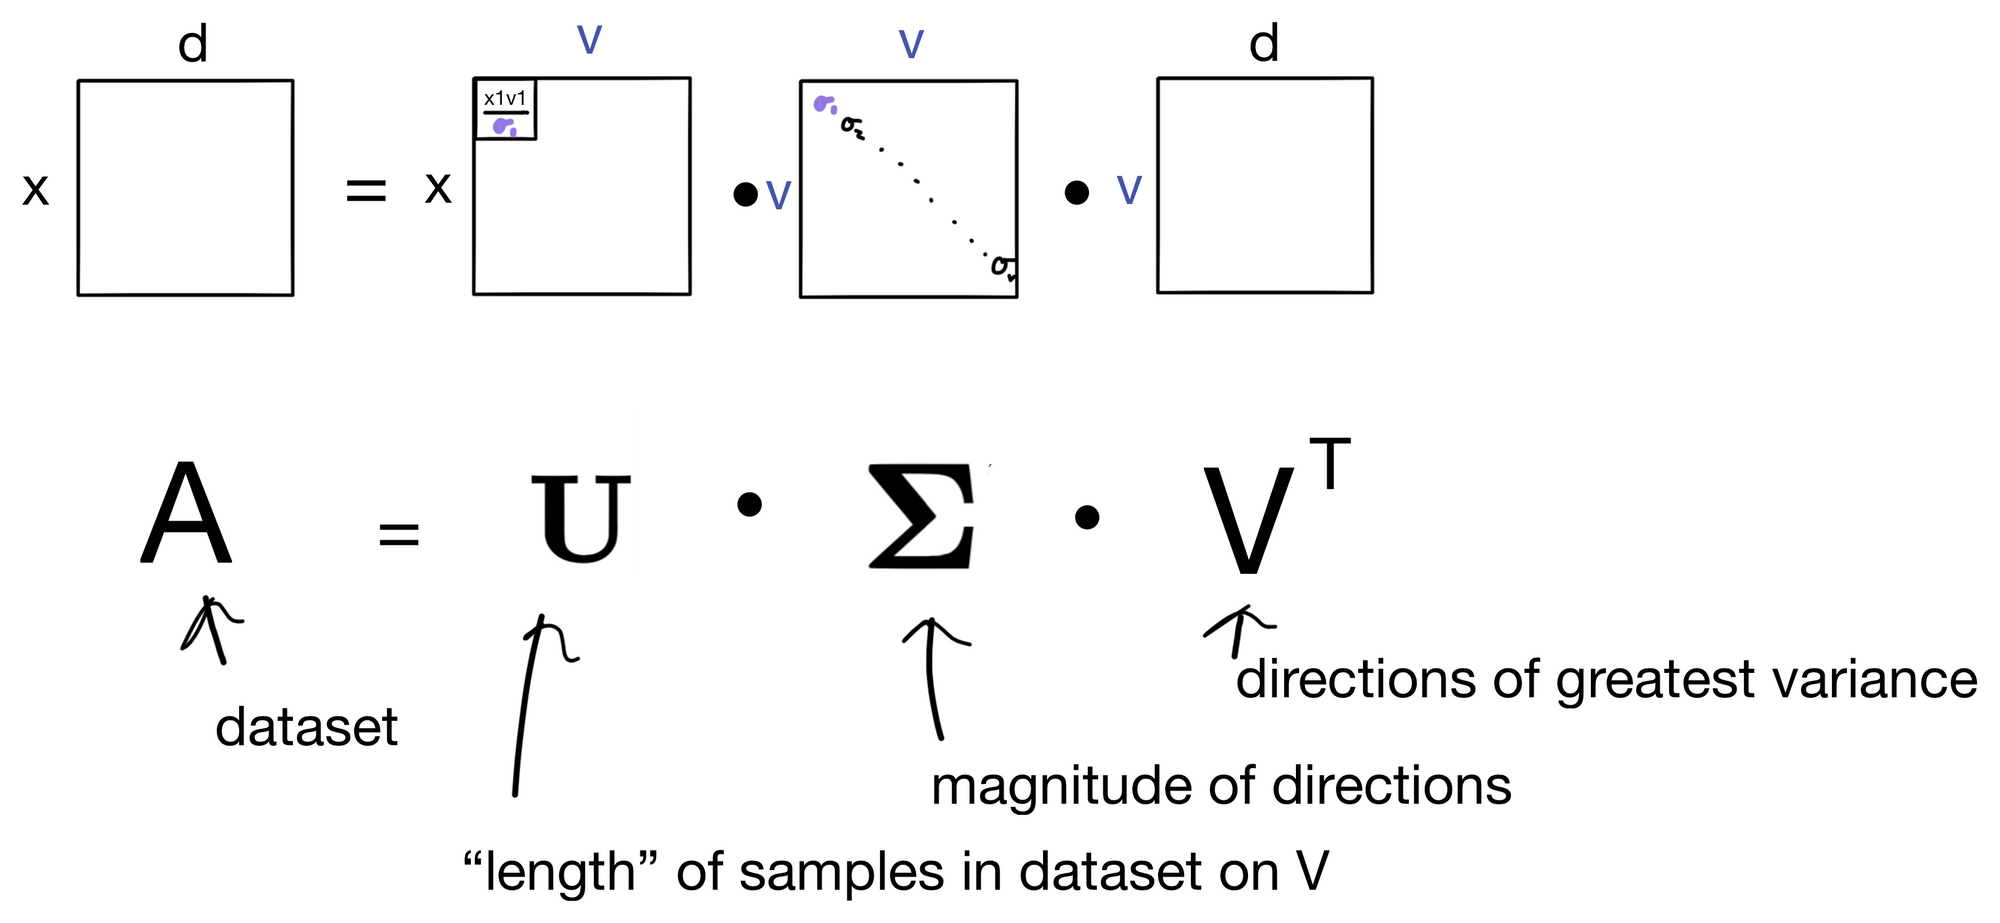

Some of these matrices' properties are:

- U, Σ, V: are unique
- U, V: are orthonormal
- Σ: a diagonal matrix where each of its value decrease from left to right (except for the diagonal, the rest are 0s)

To make things clearer, let's examine the following example

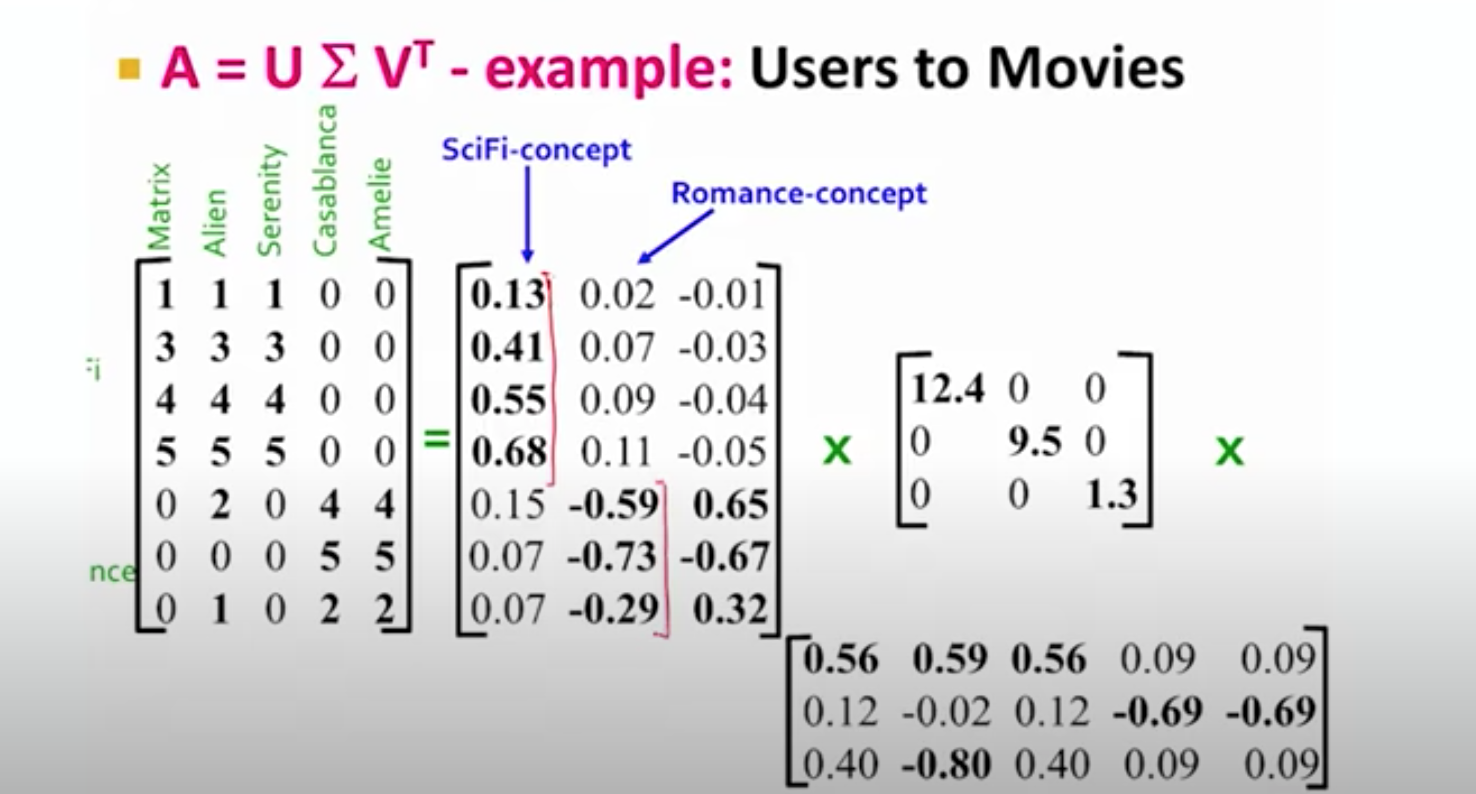

We can represent rows as users, columns as movies,and the values are ratings that users give to each movie (0 means they haven't watch the movie). As we can see, the group of people who like sci-fi movies and romance movies have already been grouped together. 

We will use SVD to decompose the matrix into 3 smaller matrices.

- For the first matrix "U", the rows represent users, first column represent sci-fi concept, second column represent romance concept, and the values represent the relationship between users and concepts.
- For the second matrix "Σ", the first value represent the strength of the sci-fi concept, the second value represent the strength of the romance concept.
- For last matrix "V", the first and second row will represent the sci-fi and romance concept respectively, the columns represent the movies, and the values represent the correspondence between the movies and the concepts.
- Notice that we ignore the third concept, this is because the third value in matrix Σ represent the strength of the third concept but since it is very small, we can ignore it focus on only the first 2.

From these matrices, we can predict a new interaction between users and movies by taking the dot product of the user vector (a row in matrix U) and the movie vector (a column of matrix V). 

### Is SVD a lie?
Now that we have seen how a matrix can be decompose and how some concept can be ignore, let's discuss about how the model train. While many usually refer to this technique as SVD, but in practice for most of the time, it is actually a truncated SVD. Since we have established that certain concepts can be ignore,a truncated SVD basically only take the most significant concepts, which will allow it to be much faster than the usual SVD.

### How will the model train?
It will first generate U and V matrices with random values and do the following steps:
- Fix one of the matrix, adjust the other with the goal to minimize the cost function
- Fix updated matrix, go to step 1 again for the other matrix
- Repeat step 1 and 2 until each maximum of iterations or the error is small enough

## What is cosine similarity
Feel free to skip this part if you already know what cosine similarity is.
![](https://storage.googleapis.com/lds-media/images/cosine-similarity-vectors.original.jpg)

Basically the angle between 2 vectors will represent their similarity. The smaller the angle the more similar the vectors and vice versa. The angle can be calculated using the following formula:

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRdPll8RKyeoDASFZakthnO2dyfYpTBD_aaWbdZs__Mtp6kPXKq1wjz1UVYPqPWpzoaWw&usqp=CAU)

### What is a cosine similarity matrix
It is a matrix with cosine similarity between all variables with each other. The below  is an example of a cosine similarity matrix, the diagonal represent the cosine similarity between a variable and itself, which is 1 because they are exactly the same.

![](https://www.machinelearningplus.com/wp-content/uploads/2018/10/soft-cosine-similarity-matrix.png)

## An overview of the process

The main process are comprised of the following 5 parts:
- Get weighted ratings for each movie: To improve the result in part 4 and 5
- Content based filtering: 
    - Given a movie title, generate similar movies
- Colaborative filtering: 
    - Given a user in the dataset, generate movie recommendation for the user
- Building a combination of the previous 2 steps: 
    - Given a user in the dataset and a movie title, genereate movie recommendation for the user
- Recommending to new users: 
    - Given a list of movies that a new user like, generate that user a list of movie recommendation

#### Import libraries

In [1]:
import matplotlib.pyplot as plt
import random
import seaborn as sns
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import accuracy
import numpy as np # linear algebra
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Get weighted ratings

The weighted rating of each movie is going to be calculated using this formula
Weighted Rating (WR) =  (v/(v+m).R)+(m/(v+m).C)
where,
- v is the number of votes for the movie
- m is the minimum votes required to be listed in the chart
- R is the average rating of the movie
- C is the mean vote across the whole report

In [2]:
m = 200
movie_df_wr = pd.read_csv("/kaggle/input/the-movies-dataset/movies_metadata.csv")
movie_df_wr = movie_df_wr[movie_df_wr["vote_count"]>=m]

In [3]:
C = np.nanmean(movie_df_wr["vote_average"])
C

6.494198895027624

In [4]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return ((v/(v+m) * R) + (m/(m+v) * C))/2

In [5]:
def get_weighted_rating(mov_id):
    return movie_df_wr[movie_df_wr["id"]==str(mov_id)].loc[:,"wr"].values[0]

In [6]:
movie_df_wr[movie_df_wr["vote_count"]==200]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
730,False,"{'id': 116661, 'name': 'The Arrival Collection...",25000000,"[{'id': 28, 'name': 'Action'}, {'id': 9648, 'n...",NaN,10547,tt0115571,en,The Arrival,Zane Ziminski is an astrophysicist who receive...,...,1996-05-31,14048372.0,115.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The greatest danger facing our world has been ...,The Arrival,False,6.1,200.0
1869,False,"{'id': 9735, 'name': 'Friday the 13th Collecti...",2200000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",NaN,9731,tt0089173,en,Friday the 13th: A New Beginning,Homicidal maniac Jason returns from the grave ...,...,1985-03-22,21930418.0,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A New Beginning to the first step in terror.,Friday the 13th: A New Beginning,False,5.1,200.0
4570,False,NaN,42000000,"[{'id': 53, 'name': 'Thriller'}]",NaN,2057,tt0218922,en,Original Sin,A young man is plunged into a life of subterfu...,...,2001-08-03,35402320.0,118.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,This is not a love story - it's a story about ...,Original Sin,False,5.8,200.0
5318,False,"{'id': 9521, 'name': ""Look Who's Talking Colle...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,11982,tt0107438,en,Look Who's Talking Now!,When Samantha LeBon hatches a scheme to spend ...,...,1993-11-05,0.0,96.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The World's Favorite Family is Back.,Look Who's Talking Now!,False,4.7,200.0
8103,False,"{'id': 105995, 'name': 'Anaconda Collection', ...",20000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",NaN,11237,tt0366174,en,Anacondas: The Hunt for the Blood Orchid,The blood orchid - A rare flower that holds th...,...,2004-08-26,70992898.0,97.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Anacondas: The Hunt for the Blood Orchid,False,4.9,200.0
12561,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 99, 'nam...",http://www.lionsgate.com/religulous/,13007,tt0815241,en,Religulous,Commentator-comic Bill Maher plays devil's adv...,...,2008-10-01,0.0,101.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Released,Heaven help us.,Religulous,False,7.2,200.0
12579,False,NaN,25000000,"[{'id': 53, 'name': 'Thriller'}]",NaN,13018,tt0800240,en,Deception,As a corporate auditor who works in a number o...,...,2008-04-24,17741298.0,107.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"When you're in this world, no one is who they ...",Deception,False,5.7,200.0
18199,False,NaN,10000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sarahskey.com.au/,53457,tt1668200,fr,Elle s'appelait Sarah,"On the night of 16 July 1942, ten year old Sar...",...,2010-09-16,17511906.0,111.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Sarah's Key,False,7.2,200.0
27830,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}]",http://www.mistressamericathemovie.com/,309245,tt2872462,en,Mistress America,"Tracy, a lonely college freshman in New York, ...",...,2015-08-14,2500431.0,84.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,From Strangers to Sisters.,Mistress America,False,6.4,200.0
37827,False,"{'id': 219691, 'name': 'I Spit on Your Grave C...",0,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",NaN,357096,tt4530884,en,I Spit on Your Grave III: Vengeance is Mine,Jennifer Hills is still tormented by the bruta...,...,2015-10-09,0.0,91.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,I Spit on Your Grave III: Vengeance is Mine,False,5.1,200.0


In [7]:
movie_df_wr["wr"] = movie_df_wr.apply(weighted_rating, axis=1)

## Content Based filtering
### Short summary
- Data preprocessing using movies_metadata.csv, keywords.csv, credits.csv
- Extract and vectorize the features that impact a movie's content
- Use cosine similarity matrix to find the similarity between each record
- Extract similar movies as the input using the matrix created

### Data preprocessing

#### Load dataset

In [8]:
movie_df = pd.read_csv("/kaggle/input/the-movies-dataset/movies_metadata.csv")
movie_keywords = pd.read_csv("/kaggle/input/the-movies-dataset/keywords.csv")
movie_credits = pd.read_csv("/kaggle/input/the-movies-dataset/credits.csv")

We are only going to take movies with more then 50 votes into account

In [9]:
movie_df = movie_df[movie_df["vote_count"]>=m]

We will work with the following 4 features

In [10]:
movie_df = movie_df[['id','original_title','overview','genres']]
movie_df.head(5)

,id,original_title,overview,genres
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
5,949,Heat,"Obsessive master thief, Neil McCauley leads a ...","[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam..."
9,710,GoldenEye,James Bond must unmask the mysterious head of ...,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '..."
11,12110,Dracula: Dead and Loving It,When a lawyer shows up at the vampire's doorst...,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam..."


We are making another title column for future purpose

In [11]:
movie_df["title"] = movie_df["original_title"].copy()
movie_df.reset_index(inplace=True, drop=True)

In [12]:
movie_keywords.head(5)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [13]:
movie_credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [14]:
# Merging movie_df with movie_keywords and movie_credits
movie_df["id"] = movie_df["id"].astype(int)
df = pd.merge(movie_df, movie_keywords, on="id")

In [15]:
df = pd.merge(df, movie_credits, on="id")

In [16]:
df.isna().sum()

id                0
original_title    0
overview          2
genres            0
title             0
keywords          0
cast              0
crew              0
dtype: int64

Since there are some nan values in the overview column, we are going to fill it with empty

In [17]:
df["overview"] = df["overview"].fillna("[]")

### Extract and vectorize features

In [18]:
#Get genres
df["genres"] = df["genres"].apply(lambda x: [i["name"] for i in eval(x)])
df["genres"] = df["genres"].apply(lambda x: ' '.join([i.replace(" ","") for i in x]))

In [19]:
# Get keywords
df["keywords"] = df["keywords"].apply(lambda x: [i["name"] for i in eval(x)])
df["keywords"] = df["keywords"].apply(lambda x: ' '.join([i.replace(" ","") for i in x]))

In [20]:
df.head(5)

,id,original_title,overview,genres,title,keywords,cast,crew
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",Animation Comedy Family,Toy Story,jealousy toy boy friendship friends rivalry bo...,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,Adventure Fantasy Family,Jumanji,boardgame disappearance basedonchildren'sbook ...,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,949,Heat,"Obsessive master thief, Neil McCauley leads a ...",Action Crime Drama Thriller,Heat,robbery detective bank obsession chase shootin...,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de..."
3,710,GoldenEye,James Bond must unmask the mysterious head of ...,Adventure Action Thriller,GoldenEye,cuba falselyaccused secretidentity computervir...,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '52fe426ec3a36847f801e14b', 'de..."
4,12110,Dracula: Dead and Loving It,When a lawyer shows up at the vampire's doorst...,Comedy Horror,Dracula: Dead and Loving It,dracula spoof,"[{'cast_id': 9, 'character': 'Count Dracula', ...","[{'credit_id': '52fe44b79251416c7503e7fb', 'de..."


Since directors play very a big role, we also need to get the director for each movie as well

In [21]:
# Get director
df["director"] = df["crew"].apply(literal_eval).apply(lambda x: [i["name"] for i in x if i["job"]=="Director"])
df["director"] = df["director"].apply(lambda x: ' '.join([i.replace(" ","") for i in x]))

In [22]:
# We have no use for crew column anymore
df.drop("crew", axis=1, inplace=True)

We are going to get the top 5 actors in a movie as they usually plays a big part in selling the movie  

In [23]:
# Get cast
df["cast"] = df["cast"].apply(lambda x: [i["name"][:5] for i in eval(x)])
df["cast"] = df["cast"].apply(lambda x: ' '.join([i.replace(" ","") for i in x]))

We will create a column where we add overview, genres, original_title, keywords, cast , and director column together. And we will add director 3 times to put more emphasis on director's role.

In [24]:
df["tags"] = df["overview"] + " " + df["genres"] + " " + df["original_title"] + " " + df["keywords"] + " " + df["cast"] + " " + df["director"] + " " +  df["director"] + " " + df["director"]

In [25]:
df["tags"][0]

"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences. Animation Comedy Family Toy Story jealousy toy boy friendship friends rivalry boynextdoor newtoy toycomestolife TomH TimA DonR JimV Walla John Annie John Erik Lauri R.Le Sarah Penn JohnLasseter JohnLasseter JohnLasseter"

In [26]:
# Drop the following column since we have no use for them anymore
df.drop(columns=["overview", "genres", "original_title", "keywords", "cast", "director"], axis=1, inplace=True)

In [27]:
df.isnull().sum()

id       0
title    0
tags     0
dtype: int64

As we can see, there are 38 null values for the column tags. Since it is relatively small compare to the total number of data we have, we are going to drop them.

In [28]:
df.drop(df[df["tags"].isnull()].index, inplace=True)

In [29]:
df.drop_duplicates(inplace=True)

In [30]:
df.shape

(3980, 3)

We are going to vectorize our data so that we can fit them into a model afterwards

In [31]:
tfidf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
vectorized_df = tfidf.fit_transform(df["tags"])

In [32]:
vectorized_df.shape

(3980, 270064)

We wiill use cosine similarity for this task

### Cosine similarity matrix

In [33]:
cosine_sim = cosine_similarity(vectorized_df)

In [34]:
cosine_sim 

array([[1.00000000e+00, 7.21908625e-03, 0.00000000e+00, ...,
        5.74387410e-03, 2.68653451e-03, 5.75617741e-04],
       [7.21908625e-03, 1.00000000e+00, 8.78749732e-03, ...,
        4.64284183e-03, 1.00314497e-02, 0.00000000e+00],
       [0.00000000e+00, 8.78749732e-03, 1.00000000e+00, ...,
        4.85561277e-03, 1.28643734e-02, 7.80399639e-03],
       ...,
       [5.74387410e-03, 4.64284183e-03, 4.85561277e-03, ...,
        1.00000000e+00, 5.97841678e-03, 9.01255463e-03],
       [2.68653451e-03, 1.00314497e-02, 1.28643734e-02, ...,
        5.97841678e-03, 1.00000000e+00, 4.54078259e-03],
       [5.75617741e-04, 0.00000000e+00, 7.80399639e-03, ...,
        9.01255463e-03, 4.54078259e-03, 1.00000000e+00]])

Now, from the consine similarity matrix, we can get the recommendation by implementing the following function. The reason this function return botht the recommended titles and it's index is for future purposes

### Getting movie recommendation

In [35]:
def recommendation_content(title):
    id_recom = df[df["title"]==title].index[0]
    distances = cosine_sim[id_recom]
    top_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x:x[1])[1:10]
    movie_list = []
    ids = []
    for i in top_list:
        movie_list.append(df.iloc[i[0]].title)
        ids.append(df.iloc[i[0]].id)
    return movie_list, ids

In [36]:
# For later purpose
def recommendation_content2(title):
    id_recom = df[df["title"]==title].index[0]
    distances = cosine_sim[id_recom]
    top_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x:x[1])[1:50]
    movie_list = []
    ids = []
    for i in top_list:
        movie_list.append(df.iloc[i[0]].title)
        ids.append(df.iloc[i[0]].id)
    return movie_list, ids

In [37]:
recommendation_content("The Matrix")[0]

['The Matrix Revolutions',
 'Bound',
 'The Matrix Reloaded',
 'Speed Racer',
 'Jupiter Ascending',
 'Cloud Atlas',
 'The Zero Theorem',
 'Commando',
 'Hackers']

As we can see, the model recommended movies that are similar to each other. However, it cannot capture a person's "taste" in movies. Therefore we will need to implement another method.

## Colabrative filtering
### Short summary
- Build a training set from the rating each user give to a movie they watched
- Fit the training set to a SVD model
- We can get movie recommendations by doing the following
    - Use the model to predict what rating the input user will give to all the movie that they haven't watch
    - Sort the movie base on the predicted rating and generate recommendations

### Build training set

We will start by loading the ratings dataset

In [38]:
ratings_df = pd.read_csv("/kaggle/input/the-movies-dataset/ratings.csv")

Then proceed by filtering the dataset with only the rows that we need

In [39]:
movie_ids = [int(x) for x in df["id"].values]
ratings_df = ratings_df[ratings_df["movieId"].isin(movie_ids)]
ratings_df.reset_index(inplace=True, drop=True)

In [40]:
ratings_df.shape

(5475972, 4)

We will build the training set by doing the following

In [41]:
reader = Reader()
data = Dataset.load_from_df(ratings_df[["userId", "movieId", "rating"]], reader=reader)
trainset = data.build_full_trainset()

### Train the SVD model

Then use the training data to train the SVD model that we are going to use to predict the a person's rating for a movie that they have never watched

In [42]:
svd = SVD()
svd.fit(trainset)

In [43]:
svd.predict(1, 302).est

3.532004970826239

We can use this fuction to generate movie recommendations for a user in the dataset 

### Getting movie recommendation

In [44]:
def get_recommendations(data, movie_md, user_id, top_n, algo):
    
    # creating an empty list to store the recommended product ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_movie_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # extracting those product ids which the user_id has not interacted yet
    non_interacted_movies = user_movie_interactions_matrix.loc[user_id][user_movie_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_movies:
        
        # predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        movie_name = movie_md[movie_md['id']==str(item_id)]['title'].values[0]
        recommendations.append((movie_name, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating products for this user

In [45]:
# get_recommendations(data=ratings_df,movie_md=movie_df, user_id=140364, top_n=10, algo=svd)

## Building a combination between the 2 techniques
### Short summary
- Use content based filtering to recommend similar movies as the input
- Predict the input user score for each recommended movie from first step
    - Sort the recommended movie according to the predicted user score

In this section, we are going to try to combine the 2 previous models in order to generate a better recommendation for users. We are also going to use weighted rating in the part to put emphasize on how good the movie actually is. 

In [46]:
def hybrid_pred(userId, title):
    # Get similar titles and its predicted score
    title_recom, ids = recommendation_content(title)
    score = []
    wr = [get_weighted_rating(x) for x in ids]
    for i in range(len(ids)):
        score.append(svd.predict(userId, ids[i]).est + wr[i]*0.1)
    return [x for (_, x) in sorted(zip(score, title_recom), reverse=True)][:10]

In [47]:
# This is for the next section
def hybrid_pred2(userId, title):
    title_recom, ids = recommendation_content2(title)
    score = []
    wr = [get_weighted_rating(x) for x in ids]
    for i in range(len(ids)):
        score.append(svd.predict(userId, ids[i]).est + wr[i]*0.2)
    return [score, title_recom]

In [48]:
hybrid_pred(5, "Inception")

['Batman Returns',
 'Batman: The Dark Knight Returns, Part 2',
 'Batman: The Dark Knight Returns, Part 1',
 'The Lego Batman Movie',
 'Batman: Year One',
 'Batman',
 'Batman vs. Robin',
 'Batman: The Killing Joke',
 'The Dark Knight']

In [49]:
recommendation_content("Inception")

(['Batman Returns',
  'Batman: The Dark Knight Returns, Part 1',
  'Batman: The Dark Knight Returns, Part 2',
  'The Lego Batman Movie',
  'Batman: The Killing Joke',
  'The Dark Knight',
  'Batman',
  'Batman: Year One',
  'Batman vs. Robin'],
 [364, 123025, 142061, 324849, 382322, 155, 268, 69735, 321528])

## Finding a similar user
### Short summary
- Find the most similar user in the dataset base on the rating they give to each movie in the list
- Use this user as input to get movie recommendations for the new user
- Use content based filtering to get similar movies with each given movie in the list
- Predict the score for each recommended title base on the user's "taste"
- Sort the list base on the score and take the top 10 recommendation

First, we load the ratings dataset to display all the users

In [50]:
ratings_df = pd.read_csv("/kaggle/input/the-movies-dataset/ratings.csv")
ratings_df.drop("timestamp", inplace=True, axis=1)

Define a function to get the movie ids

In [51]:
def find_movieids(title_lst):
    # Get a list of movie ids from a list of movie titles
    return [int(movie_df[movie_df["original_title"]==x].id.values[0]) for x in title_lst]

The following function will extract a similar user based on a list of movies that we watch and love. We will do it by taking the sum of ratings for each of the input movies then take the user with highest rating sum as the output. We can also use cosine similarity for this task, but it is going be extremely slow and computationally expensive.

In [52]:
def similar_user(user_input):
    # Take in a list of movie titles and output the most similar user
    # Get the input movie ids
    user_inputId = find_movieids(user_input)
    print(user_inputId)
    # create a copy of ratings_df dataset to work with
    ratings_new = ratings_df.copy()
    user_score = {}
    for x in user_inputId:
        cur_movie = ratings_df[ratings_df["movieId"] == x]
        for u, r in zip(cur_movie["userId"], cur_movie["rating"]):
            user_score[u] = user_score.get(u, 0) + r
    max_user, rating = ratings_df['userId'][0], 0
    for u in user_score:
        if user_score[u] > rating:
            max_user, rating = u, user_score[u]
    return max_user

We will create a function that generate recommendations and its score for each of the input movies. Sort the result and return the top 10 best recommendation base on the model's result.

In [53]:
def generate_recommendation_userid(user_input, userId=1):
    score_lst = []
    title_lst = []
    for x in user_input:
        result = hybrid_pred2(userId, x)
        for y in range(len(result[0])):
            if result[1][y] not in title_lst:
                title_lst.append(result[1][y])
                score_lst.append(result[0][y])
    recommended_title = pd.Series(title_lst, index=score_lst).sort_index(ascending=False)
    recommended_title = recommended_title.values
    unique_check_lst = []
    if len(np.unique(title_lst)) > 10:
        result = []
        for i in range(10):
            if recommended_title[i] not in unique_check_lst:
                result.append(recommended_title[i])
                unique_check_lst.append(recommended_title[i])
        return result
    else:
        result = []
        for i in range(len(np.unique(title_lst))):
            if recommended_title.iloc[i,0] not in unique_check_lst:
                result.append(recommended_title[i])
                unique_check_lst.append(recommended_title[i])
        return result

In [54]:
def generate_recommendation(user_input):
    if len(user_input) > 5:
        user_input = random.choices(user_input_test, k=5)
    return generate_recommendation_userid(user_input, similar_user(user_input))

In [55]:
user_input_test = ["The Dark Knight", "The Dark Knight Rises"]

In [56]:
result_test = generate_recommendation_userid(user_input_test, 1)

In [57]:
find_movieids(user_input_test)

[155, 49026]

In [58]:
result_test

['Zodiac',
 'Never Back Down',
 'Run Fatboy Run',
 'The Devil Wears Prada',
 'Gone Girl',
 'Live Free or Die Hard',
 'Shutter Island',
 'R.I.P.D.',
 'The Avengers',
 'Kung Fury']

This notebook is inspired by the following 2 notebooks:
- https://www.kaggle.com/code/rounakbanik/movie-recommender-systems by ROUNAK BANIK
- https://www.kaggle.com/code/padmanabhanporaiyar/imdb-movies-all-types-of-recommender-system by PADMANABHAN PORAIYAR

## Conclusion
In this notebook we have used 2 main methods content based filtering and collaborative filtering, then we make a hybrid method between the two. Finally, we found a new way of generating movie recommendations for completely new users.